In [23]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [24]:
import os

# Set Keras backend
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

# Standard Library imports
import json
import math

# Third-party imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import keras
from keras import losses, ops, optimizers, metrics
from keras.optimizers import schedules
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import KFold
import keras_hub

import numpy as np
import tensorflow as tf
import cv2


In [25]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define the learning rate schedule

In [27]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

In [ ]:
# Parameters
w
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5
EPOCHS = 50
GAMMA = 2.0


In [29]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

Found 336 files belonging to 4 classes.


In [30]:
total_images = 336
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)

In [33]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
gamma_value = 1.5  # Define the gamma value to apply (adjust as needed)

for image, label in dataset:
    # Add the original image
    images.append(image[0])  # Remove the extra batch dimension
    labels.append(label[0])  # Remove the extra batch dimension for label

    # Apply gamma transformation and add the transformed image
    gamma_transformed_image = tf.image.adjust_gamma(image[0], gamma=gamma_value)
    images.append(gamma_transformed_image)
    labels.append(label[0])  # Same label for the gamma-transformed image

# Convert lists to numpy arrays for KFold processing
images = np.array([img.numpy() for img in images])  # Convert each tensor to a NumPy array
labels = np.array([lbl.numpy() for lbl in labels])

# Check the shape to confirm
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Found 336 files belonging to 4 classes.
Images shape: (672, 224, 224, 3)
Labels shape: (672,)


In [34]:
from sklearn.model_selection import StratifiedKFold


kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=43)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0
best_weights = None

train_accuracy_history = []
val_accuracy_history = []

for train_index, val_index in kf.split(images, labels):
    print(f"\nTraining fold {fold_no}...")

    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    # train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    # val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
        metrics=["accuracy"]
    )


    history = model.fit(train_dataset, epochs=12, validation_data=val_dataset)


    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])


    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()

    fold_no += 1



Training fold 1...
Epoch 1/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.3066 - loss: 1.3789 - val_accuracy: 0.4519 - val_loss: 1.3763
Epoch 2/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step - accuracy: 0.3978 - loss: 1.3505 - val_accuracy: 0.4444 - val_loss: 1.3066
Epoch 3/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - accuracy: 0.4221 - loss: 1.2886 - val_accuracy: 0.4519 - val_loss: 1.2162
Epoch 4/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 320ms/step - accuracy: 0.4221 - loss: 1.2396 - val_accuracy: 0.4519 - val_loss: 1.2452
Epoch 5/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.4221 - loss: 1.1968 - val_accuracy: 0.4519 - val_loss: 1.1939
Epoch 6/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.4806 - loss: 1.0921 - val_accuracy: 0.4815 - val_loss: 1.0415
Epoch 7/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 317ms/step - accuracy: 0.6195 - loss: 0.9233 - val_accuracy: 0.6296 - val_loss: 0.8191
Epoch 8/12
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.6647 - loss: 0.7599

In [35]:
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

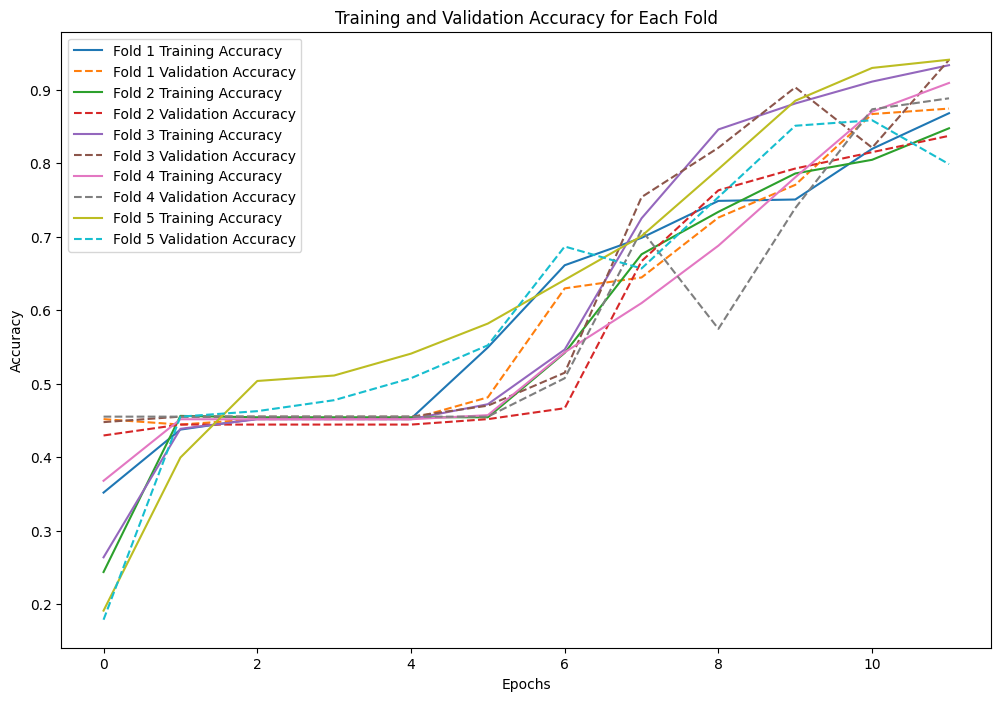

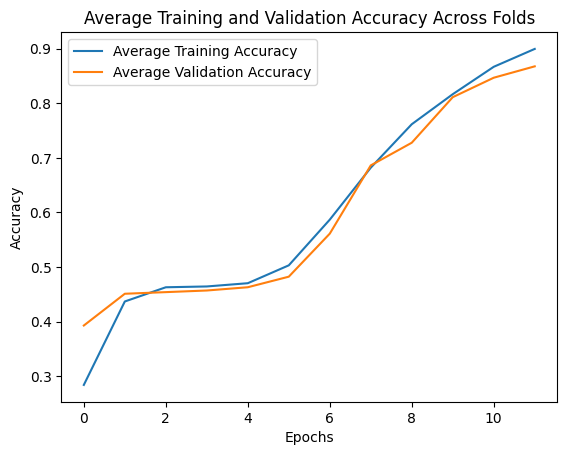

In [36]:
# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
final_model = keras.Model(inputs=inputs, outputs=outputs)
final_model.set_weights(best_weights)


final_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
    metrics=["accuracy"]
)

full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

history = final_model.fit(full_train_dataset, epochs=15)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 35s 881ms/step - accuracy: 0.9365 - loss: 0.2882
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 392ms/step - accuracy: 0.9642 - loss: 0.2439
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.9761 - loss: 0.2015
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.9643 - loss: 0.1888
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.9631 - loss: 0.1649
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.9721 - loss: 0.1314
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.9941 - loss: 0.0847
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - accuracy: 0.9948 - loss: 0.0668
Epoch 9/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.9963 - loss: 0.0669
Epoch 10/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.9963 - loss: 0.0510
Epoch 11/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.9969 - loss: 0.0439
Epoch 12/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/s

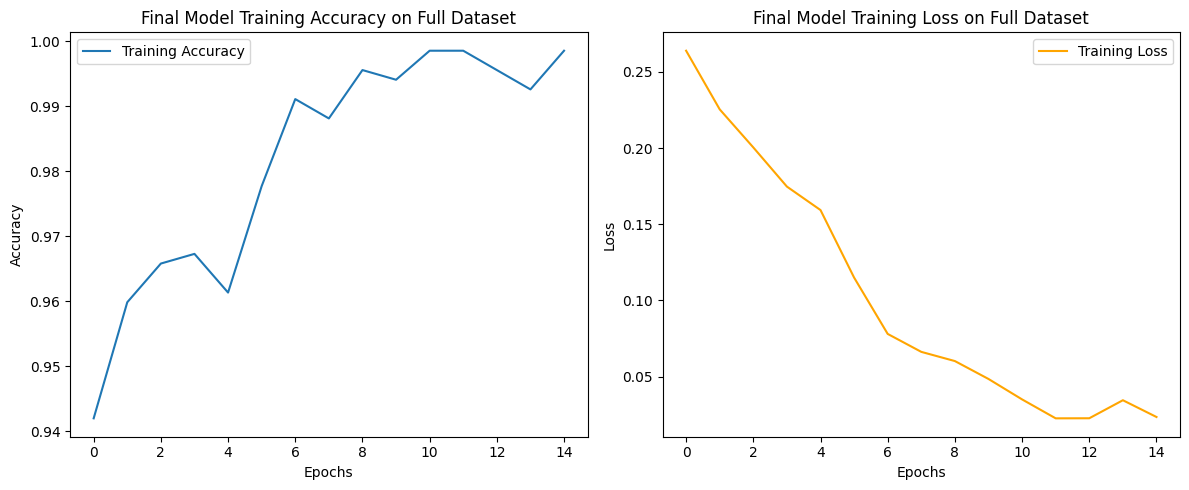

In [38]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

 # Apply gamma and normalize

# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 55 files belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9081 - loss: 0.2733

Test Loss: 0.28312134742736816
Test Accuracy: 0.9090908765792847


Found 55 files belonging to 4 classes.
Class names: ['KO', 'OK', 'RzKO', 'RzOK']
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.8977 - loss: 0.3074

Test Loss: 0.28312137722969055
Test Accuracy: 0.9090908765792847
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<Figure size 800x800 with 0 Axes>

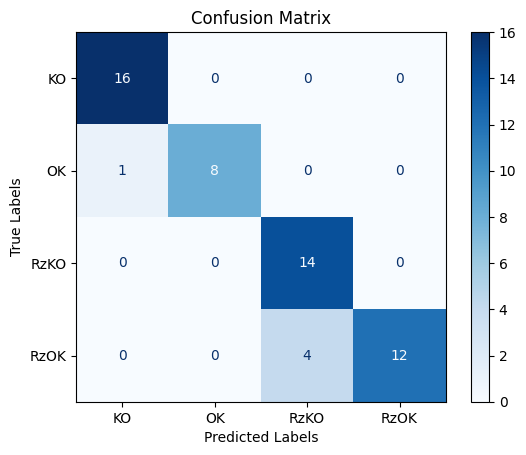

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

# Retrieve class names from the dataset
class_names = test_dataset.class_names
print("Class names:", class_names)


# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predictions and true labels for the test dataset
y_pred = []
y_true = []

for images, labels in test_dataset:
    predictions = final_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Plot the confusion matrix with class names
plt.figure(figsize=(8, 8))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [45]:
final_model.save_weights("/content/drive/MyDrive/3D/final_model.weights.h5")
